# Report

Load Data:

In [2]:
import csv
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import glob
import os
import matplotlib.gridspec as gridspec
from matplotlib import rc
from scipy.odr import Model, RealData,ODR

all_data = []

# Load all the CSV files
for cFile in glob.glob("*.csv"):
    data = {
        "voltage": float(cFile.split(".")[0][:-2]),
        "xs": [],
        "ys": []
    }
    
    with open(cFile) as csvfile:
        dialect = csv.Sniffer().sniff(csvfile.read(1024))
        csvfile.seek(0)
        lines = csv.reader(csvfile, dialect)

        header = True
        for line in lines:
            if header:
                header = False
                continue

            line = line[:2] # only grab first 2 elements

            pline = list(map(lambda x: np.float64(x), line))
            data["xs"].append(pline[0])
            data["ys"].append(pline[1])
    data["xs"] = np.float64(data["xs"])
    data["ys"] = np.float64(data["ys"])
    all_data.append(data)


This gives us an overview of all our data:

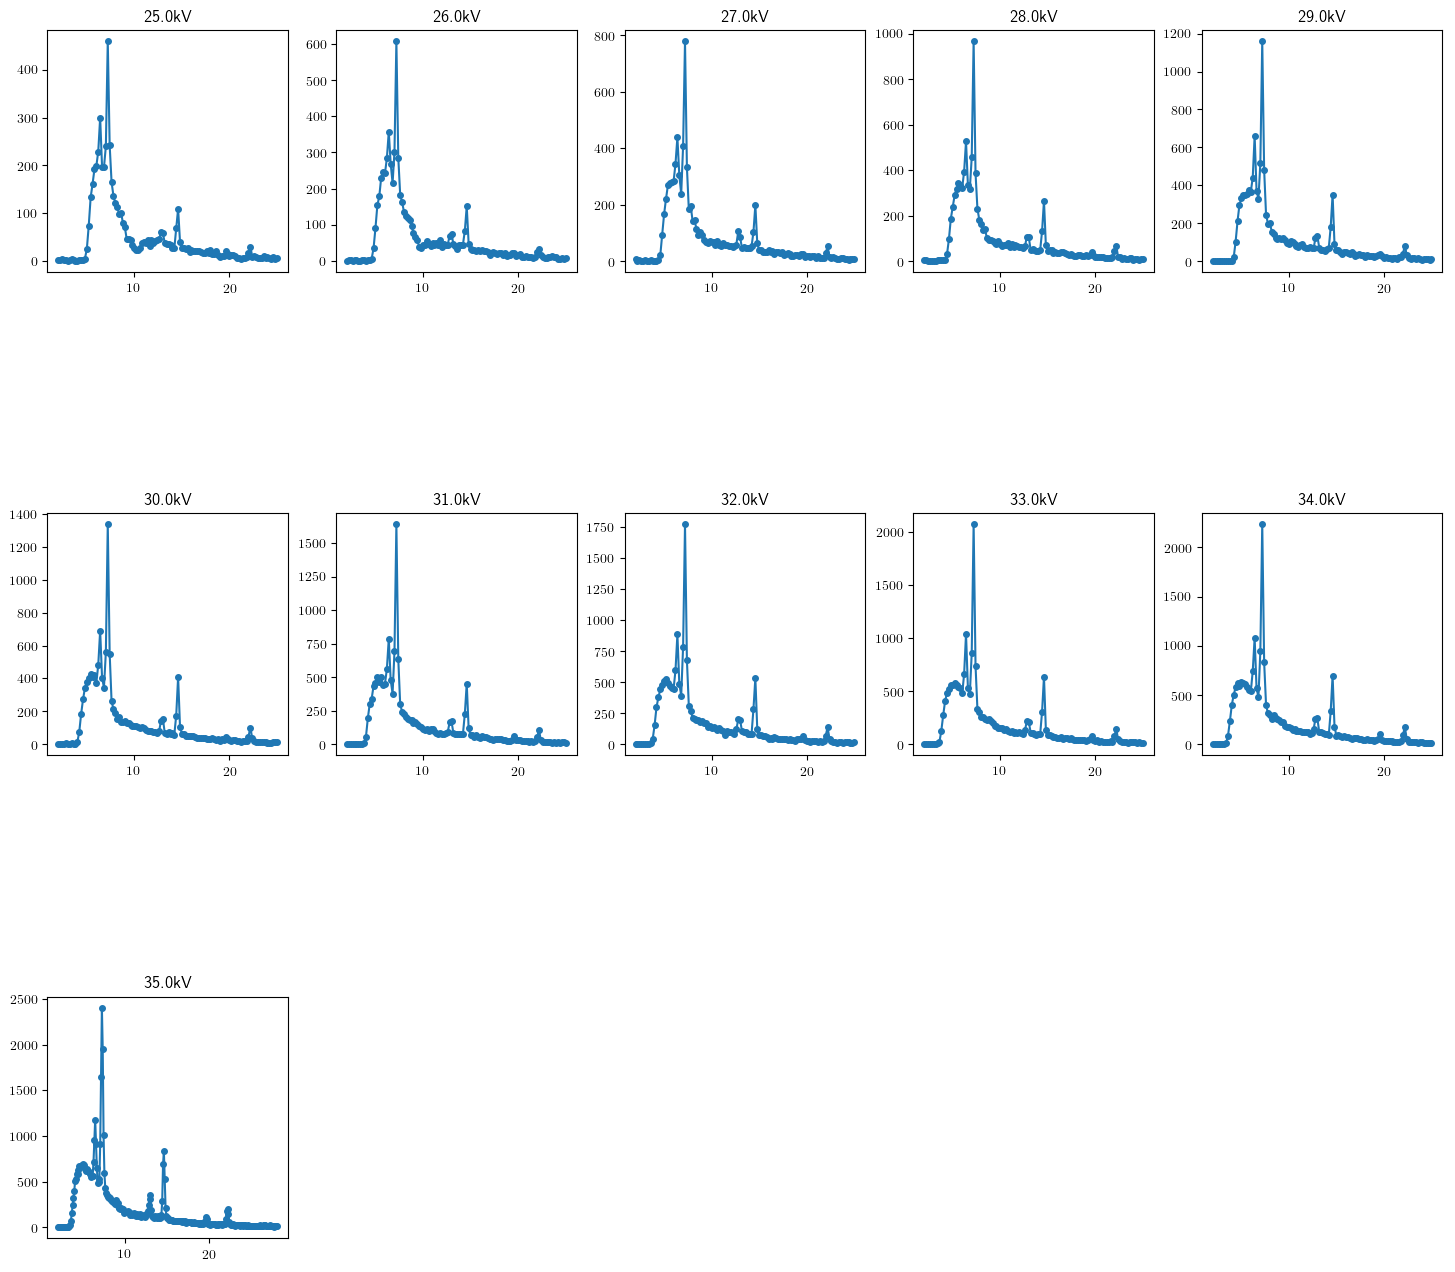

In [3]:
# plot all data
fig1 = plt.figure(figsize=(18, 16), dpi=100, facecolor='w', edgecolor='k')

cols = 5
gs = gridspec.GridSpec(len(all_data) // cols + 1, cols)
gs.update(hspace=1)

ax = []
for i, data in enumerate(all_data):
    row = (i // cols)
    col = i % cols
    ax.append(fig1.add_subplot(gs[row, col]))
    ax[-1].set_title("{}kV".format(data["voltage"]))
    ax[-1].plot(data["xs"], data["ys"], 'o', ls='-', ms=4)

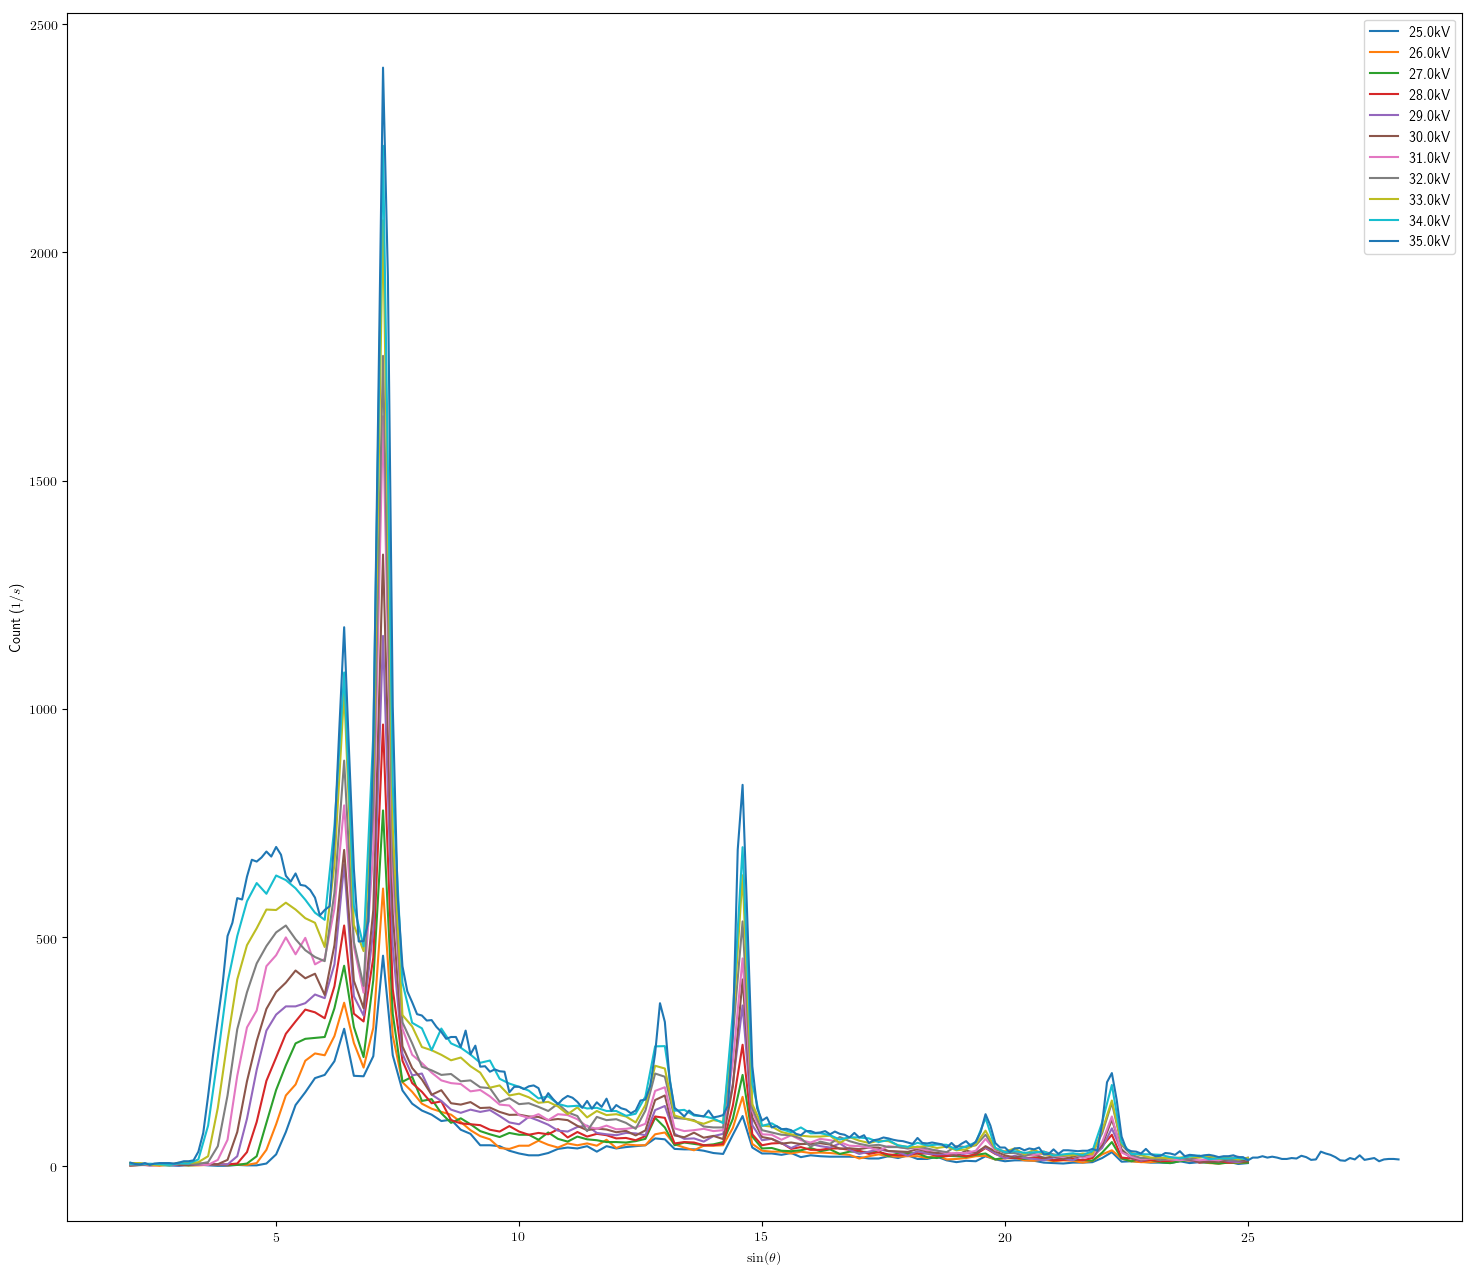

In [4]:
# Combined plot 

fig2 = plt.figure(figsize=(18, 16), dpi=100, facecolor='w', edgecolor='k')

for i, data in enumerate(all_data):
    plt.plot(data["xs"], data["ys"], label="{}kV".format(data["voltage"]))
plt.xlabel(r"$\sin(\theta)$")
plt.ylabel(r"Count ($1/s$)")
plt.gca().legend()



We can now apply a cut to see just the beginning portion of the graph to find a straight line. In this particular cut we choose
$2 \leq x \leq 7$.

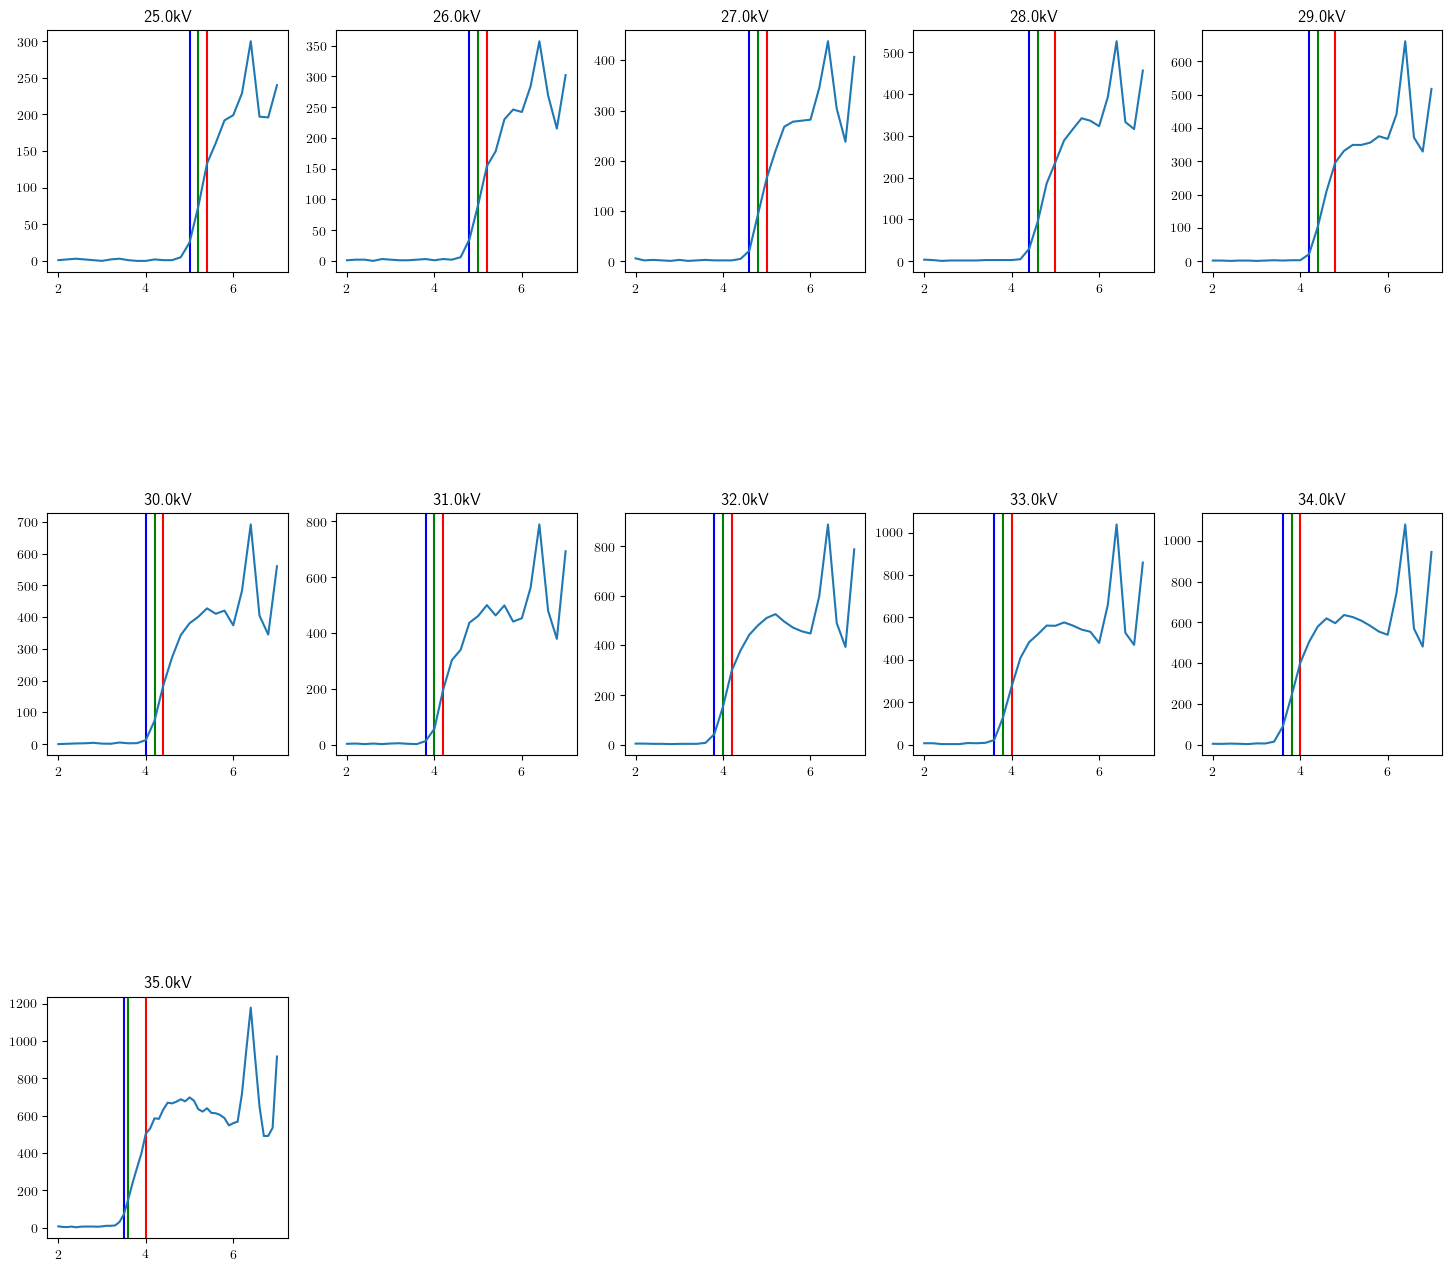

In [27]:
# 

fig3 = plt.figure(figsize=(18, 16), dpi=100, facecolor='w', edgecolor='k')

min_cut_x = 2
max_cut_x = 7

cols = 5
gs = gridspec.GridSpec(len(all_data) // cols + 1, cols)
gs.update(hspace=1)

ax2 = []
for i, data in enumerate(all_data):
    row = (i // cols)
    col = i % cols
    ax2.append(fig3.add_subplot(gs[row, col]))
    
    min_cut = np.argmax(data["xs"]>min_cut_x-1)
    max_cut = np.argmax(data["xs"]>max_cut_x)
    
    sxs = data["xs"][min_cut:max_cut]
    sys = data["ys"][min_cut:max_cut]
    
    #line_begin = np.argmax(np.gradient(np.gradient(sys))< 0.01)
    a = np.gradient(np.gradient(sys))
    zero_crossings = np.where(np.diff(np.sign(a)))[0]
    
    n_cross = []
    
    for crossing in zero_crossings:
        if np.gradient(sys)[crossing] > 30:
            n_cross.append(crossing)

    line_mid = sxs[n_cross[0]]
    norm_grad = np.gradient(sys)/np.max(np.gradient(sys))

    
    x_i = 0
    while True:
        if abs(norm_grad[x_i + n_cross[0]] - norm_grad[n_cross[0]]) > 0.1 * norm_grad[n_cross[0]]:
            break
        x_i += 1
    x_max = sxs[x_i +  n_cross[0]]

    
    
    x_i = 0
    while True:
        if abs(norm_grad[-x_i + n_cross[0]] - norm_grad[n_cross[0]]) > 0.1 * norm_grad[n_cross[0]]:
            break
        x_i += 1
    x_min = sxs[-x_i +  n_cross[0]]

    ax2[-1].axvline(x=line_mid, color="g")
    ax2[-1].axvline(x=x_min, color="b")
    ax2[-1].axvline(x=x_max, color="r")
    
    ax2[-1].plot(sxs,sys ,  label="{}kV".format(data["voltage"]))
    ax2[-1].set_title("{}kV".format(data["voltage"]))
    all_data[i]["x_min_i"] = -x_i +  n_cross[0]
    all_data[i]["x_max_i"] = x_i +  n_cross[0]

    #plt.xlabel(r"$\sin(\theta)$")
    #plt.ylabel(r"Count ($1/s$)")
    #ax2[-1].gca().legend()


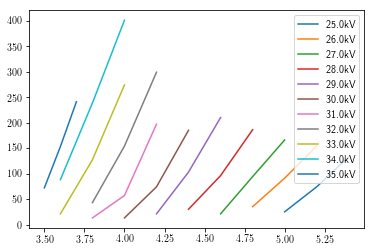

In [28]:
for data in all_data:
    sxs = data["xs"][data["x_min_i"]:data["x_max_i"]+1]
    sys = data["ys"][data["x_min_i"]:data["x_max_i"]+1]
    plt.plot(sxs,sys,label="{}kV".format(data["voltage"]))
    plt.legend()


h = 7.091917142005849 +- 0.7562798209764191 x10^-34


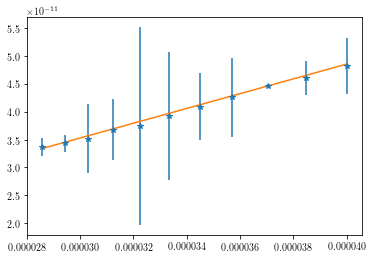

In [29]:

def linear_model(x,a,b):
    return a*x + b


d = 5.6402e-10/2

plt.figure()
final_xs = []
final_ys = []
sigma_ys = []


for data in all_data:

    sxs = data["xs"][data["x_min_i"]:data["x_max_i"]+1]
    sys = data["ys"][data["x_min_i"]:data["x_max_i"]+1]
    (gradient, yint), pcov = curve_fit(liner_model,sxs,sys,sigma=np.repeat(0.03, len(sys)))
    
    min_wavelength = 2 * d* np.sin(np.radians(-yint/gradient)) 
    
    min_wv_err = abs(2 * d* np.sin(np.radians(-(yint + pcov[1,1]**0.5)/(gradient + pcov[0,0]**0.5))) -
                     2 * d* np.sin(np.radians(-yint/gradient)) )
    final_ys.append(min_wavelength)
    sigma_ys.append(min_wv_err)
    final_xs.append(1/(data["voltage"]*10**3))

final_xs = np.float64(final_xs)
final_ys = np.float64(final_ys)
sigma_ys = np.float64(sigma_ys)
    

(gradient, yint), pcov = curve_fit(liner_model,final_xs,final_ys, sigma=sigma_ys, absolute_sigma=True)


    
plt.errorbar(final_xs, final_ys, yerr=sigma_ys, fmt="*")

line_xs = np.linspace(np.min(final_xs), np.max(final_xs), 500)
line_ys = linear_model(line_xs, gradient, yint)

plt.plot(line_xs,line_ys)



h = (1.602e-19) * gradient/(3e8)
h_err = abs((1.602e-19) * (gradient + pcov[0,0]**0.5)/(3e8) - (1.602e-19) * gradient/(3e8))
print("h = {} +- {} x10^-34".format(h*10**34, h_err*10**34))
    